# Secondary Malignancies

[Benjamin Chan](http://careers.stackoverflow.com/benjaminchan)  

## Load data

Load the data from [GitHub](https://github.com/benjamin-chan/AEAfterBreastCaACT/tree/master/SecondaryMalignancies).

In [1]:
if (!require(openxlsx)) {install.packages("openxlsx", dependencies=TRUE, repos="https://cloud.r-project.org")}
library(openxlsx)
if (!require(data.table)) {install.packages("data.table", dependencies=TRUE, repos="https://cloud.r-project.org")}
library(data.table)
url <- "https://github.com/benjamin-chan/AEAfterBreastCaACT/raw/master/SecondaryMalignancies/SecondaryMalignancies_Data_BG_3_4.xlsx"
f <- tempfile()
download.file(url, f, mode="wb")
sheets <- getSheetNames(f)
# sheets
D <- read.xlsx(f, sheet = sheets[1], startRow = 3, colNames = FALSE)
D <- data.table(D)
oldnames <- names(D)
newnames <- c("id",
              "authorYear",
              "trial",
              "quality",
              "arm",
              "nRandomized",
              "nITT",
              # "pctCompletingTx",
              "medianFU",
              "regimen",
              "anthracyclineType",
              "anthracyclineTotalDose",
              "anthracyclineDuration",
              "anthracyclineCourses",
              "cyclophosphamideDose",
              "cyclophosphamideDuration",
              "cyclophosphamideCourses",
              "taxaneType",
              "taxaneTotalDose",
              "taxaneDuration",
              "taxaneCourses",
              "fluoroucilTotalDose",
              "fluoroucilDuration",
              "fluoroucilCourses",
              "otherTxDetails",
              "malAML",
              "malMDS",
              "malAMLOrMDS",
              "malNonBreastSolid",
              "malNonBreastSolidType",
              "malOtherBloodCancers",
              "malSMRelatedDeaths",
              "malSecondPrimary",
              "NOTES")
setnames(D, oldnames, newnames[1:33])

Loading required package: openxlsx
Loading required package: data.table


## Tidy data

Create a `rowid` variable.
This will be handy later.

In [2]:
D <- D[, rowid := .I]

Input missing data for Bergh (2000); row was split.

In [3]:
col <- grep("^cyclophosphamide", names(D), invert = TRUE)
D[11, col] <- D[10, col, with = FALSE]
# D[11, ]
# D[10, ]

Fix trial column for Romond (2005).

In [4]:
D <- D[grep("Romond", authorYear), trial := gsub("&N", "& N", trial)]

Make `medianFU` numeric.

In [5]:
D <- D[grep("-", medianFU, invert = TRUE), medianFUNum := round(as.numeric(medianFU), digits = 2)]
x <- D[grep("-", medianFU), medianFU]
x <- as.numeric(unlist(strsplit(x, "-")))
x1 <- x[seq(1, length(x), 2)]
x2 <- x[seq(2, length(x), 2)]
xbar <- rowMeans(cbind(x1, x2))
D <- D[grep("-", medianFU), medianFUNum := xbar]
D <- D[,
       `:=` (medianFUChar = medianFU,
             medianFU = medianFUNum,
             medianFUNum = NULL)]
unique(D[as.character(medianFU) != medianFUChar, .(medianFU, medianFUChar)])
D <- D[, medianFUChar := NULL]

,medianFU,medianFUChar
1,38.3,38.299999999999997
2,73,71-75
3,99.6,99.600000000000009
4,28.8,28.799999999999997


Recode mal* values of `NR` and `-` to `NA`.

In [6]:
recode <- function(x) {
    missval <- c("-", "NR", " ")
    vec <- D[, get(x)]
    vec[vec %in% missval] <- NA
    vec
}
col <- grep("^mal", names(D), value = TRUE)
for (i in 1:length(col)) {
    D[, col[i]] <- recode(col[i])
}

Substitute non-numeric text in mal* values.

In [7]:
substitute <- function(x) {
    vec <- D[, get(x)]
    vec <- gsub("[[:alpha:]]", "", vec)
    vec
}
col <- grep("^mal", names(D), value = TRUE)
for (i in 1:4) {
    # Only substitute a subset of mal* columns
    D[, col[i]] <- substitute(col[i])
}

Convert mal* values to numeric.

In [8]:
for (i in 1:4) {
    # Only convert a subset of mal* columns
    D <- D[, col[i] := as.numeric(get(col[i]))]
}

The `malAMLOrMDS` column, as entered, captures number of AML or MDS malignancies if the study reported them grouped as opposed to separately.
If the study reported them as separately, then these counts are captures in the `malAML` and `malMDS` columns.
I.e., the `malAML`, `malMDS`, and `malAMLOrMDS` columns are mutually exclusive counts.
We want to create another column, `malAMLOrMDSTotal`, to be non-mutually exclusive from `malAML`, `malMDS`, and `malAMLOrMDS`.
If none of the `malAML`, `malMDS`, and `malAMLOrMDS` values are populated, then set `malAMLOrMDSTotal` to `NA`, also.
NOTE: Couldn't get this to work: [http://stackoverflow.com/a/16513949/1427069](http://stackoverflow.com/a/16513949/1427069).

In [9]:
s <- sample(D[, rowid], 12)
malAMLOrMDSTotal <- rowSums(D[, .(malAML, malMDS, malAMLOrMDS)], na.rm=TRUE)
D <- D[, malAMLOrMDSTotal := malAMLOrMDSTotal]
D <- D[is.na(malAML) & is.na(malMDS) & is.na(malAMLOrMDS), malAMLOrMDSTotal := NA]
D[s, .(rowid, malAML, malMDS, malAMLOrMDS, malAMLOrMDSTotal)]

,rowid,malAML,malMDS,malAMLOrMDS,malAMLOrMDSTotal
1,68,NA,NA,NA,NA
2,89,NA,NA,NA,NA
3,55,4,2,NA,6
4,81,NA,NA,NA,NA
5,10,0,0,NA,0
6,5,NA,NA,NA,NA
7,93,2,NA,NA,2
8,31,6,2,NA,8
9,33,0,0,NA,0
10,58,NA,NA,NA,NA


Remove text from `nITT` column.

In [10]:
D <- D[authorYear == "Misset (1996)" & arm == 2, nITT := "137"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 1, nITT := "210"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 2, nITT := "197"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 3, nITT := "195"]
D <- D[, nITT := as.integer(nITT)]

Clean up the `regimen` and `dose` columns.

In [11]:
D <- D[, regimen := gsub("\\s$", "", regimen)]
D <- D[, regimen := gsub("\\r\\n", " ", regimen)]
doseVar <- grep("dose", names(D), ignore.case = TRUE, value = TRUE)
for (i in 1:length(doseVar)) {
    D <- D[, doseVar[i] := gsub("\\r\\n", " ", get(doseVar[i]))]
}
D[, .N, c("regimen", doseVar), with = TRUE][order(regimen)]
write.table(D[, .N, c("regimen", doseVar), with = TRUE][order(regimen)],
            file = "regimens.md",
            sep = " | ", quote = FALSE,
            row.names = FALSE)

,regimen,anthracyclineTotalDose,cyclophosphamideDose,taxaneTotalDose,fluoroucilTotalDose,N
1,3 FEC 50,50,500,NA,500,1
2,A-C,81,2400,NA,NA,1
3,A-CMF,75,NA,NA,NA,1
4,A-T-C,60,600,175,NA,2
5,A-T-CMF,75,NA,100,NA,1
6,AC,60,600,NA,NA,8
7,AC,60,1200,NA,NA,3
8,AC,60,2400,NA,NA,2
9,AC,"60, 75, 90",600,NA,NA,1
10,AC,54,1200,NA,NA,1


Calculate cumulative dose: $\text{total dose} \times \text{number of courses}$.

In [12]:
D <- D[, anthracyclineTotalDose := as.numeric(anthracyclineTotalDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", anthracyclineTotalDose := 75]
D <- D[authorYear == "Henderson (2003)", anthracyclineTotalDose := 75]
D <- D[authorYear == "Colleoni (2009)" & regimen == "AC-CMF", anthracyclineTotalDose := 75]
D <- D[, cyclophosphamideDose := as.numeric(cyclophosphamideDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", cyclophosphamideDose := 900]
D <- D[authorYear == "Henderson (2003)", anthracyclineTotalDose := 75]
D <- D[, taxaneCourses := as.numeric(taxaneCourses)]
D <- D[authorYear == "Shulman (2014)" & regimen == "T" & arm == 3, taxaneCourses := 4]
D <- D[authorYear == "Shulman (2014)" & regimen == "T" & arm == 4, taxaneCourses := 6]
D <- D[, fluoroucilTotalDose := as.numeric(fluoroucilTotalDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", fluoroucilTotalDose := 600]
D <- D[authorYear == "Joensuu (2012)" & regimen == "TX-CEX", fluoroucilTotalDose := NA]
D <- D[,
       `:=` (anthracyclineCumulDose = anthracyclineTotalDose * anthracyclineCourses,
             cyclophosphamideCumulDose = cyclophosphamideDose * cyclophosphamideCourses,
             taxaneCumulDose = as.numeric(taxaneTotalDose) * taxaneCourses,
             fluoroucilCumulDose = fluoroucilTotalDose * fluoroucilCourses)]
D[, .(authorYear, regimen, anthracyclineCumulDose, anthracyclineTotalDose, anthracyclineCourses)]
D[, .(authorYear, regimen, cyclophosphamideCumulDose, cyclophosphamideDose, cyclophosphamideCourses)]
D[, .(authorYear, regimen, taxaneCumulDose, taxaneTotalDose, taxaneCourses)]
D[, .(authorYear, regimen, fluoroucilCumulDose, fluoroucilTotalDose, fluoroucilCourses)]

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercion

,authorYear,regimen,anthracyclineCumulDose,anthracyclineTotalDose,anthracyclineCourses
1,Fisher (1990),AC,240,60,4
2,Fisher (1990),AC-CMF,240,60,4
3,Fisher (1990),CMF,NA,NA,NA
4,Misset (1996),CMF,NA,NA,NA
5,Misset (1996),AVCF,360,30,12
6,Fisher (1999),AC,240,60,4
7,Fisher (1999),AC,240,60,4
8,Fisher (1999),AC,240,60,4
9,Bergh (2000),FEC Tailored,NA,NA,9
10,Bergh (2000),FEC CTCb,180,60,3


,authorYear,regimen,cyclophosphamideCumulDose,cyclophosphamideDose,cyclophosphamideCourses
1,Fisher (1990),AC,2400,600,4
2,Fisher (1990),AC-CMF,2400,600,4
3,Fisher (1990),CMF,NA,NA,NA
4,Misset (1996),CMF,NA,NA,NA
5,Misset (1996),AVCF,14400,1200,12
6,Fisher (1999),AC,4800,1200,4
7,Fisher (1999),AC,4800,2400,2
8,Fisher (1999),AC,9600,2400,4
9,Bergh (2000),FEC Tailored,NA,NA,9
10,Bergh (2000),FEC CTCb,1200,600,2


,authorYear,regimen,taxaneCumulDose,taxaneTotalDose,taxaneCourses
1,Fisher (1990),AC,NA,NA,NA
2,Fisher (1990),AC-CMF,NA,NA,NA
3,Fisher (1990),CMF,NA,NA,NA
4,Misset (1996),CMF,NA,NA,NA
5,Misset (1996),AVCF,NA,NA,NA
6,Fisher (1999),AC,NA,NA,NA
7,Fisher (1999),AC,NA,NA,NA
8,Fisher (1999),AC,NA,NA,NA
9,Bergh (2000),FEC Tailored,NA,NA,NA
10,Bergh (2000),FEC CTCb,NA,NA,NA


,authorYear,regimen,fluoroucilCumulDose,fluoroucilTotalDose,fluoroucilCourses
1,Fisher (1990),AC,NA,NA,NA
2,Fisher (1990),AC-CMF,NA,NA,NA
3,Fisher (1990),CMF,NA,NA,NA
4,Misset (1996),CMF,NA,NA,NA
5,Misset (1996),AVCF,19200,1600,12
6,Fisher (1999),AC,NA,NA,NA
7,Fisher (1999),AC,NA,NA,NA
8,Fisher (1999),AC,NA,NA,NA
9,Bergh (2000),FEC Tailored,NA,NA,9
10,Bergh (2000),FEC CTCb,NA,NA,NA


## Summarize

Define some functions.

In [13]:
calcPct <- function (x, n) {
  prec <- "%.3g"
  sprintf(paste0(prec, "%%"),
          median(x / n, na.rm = TRUE) * 100)
}
calcRate <- function (x, n, y) {
  prec <- "%.3g"
  py <- 10000
  sprintf(paste(prec, "per %s p-y"),
          median(x / (n * (y / 12)), na.rm=TRUE) * py,
          py)
}

Summarize the regimens.

In [14]:
D[,
  `:=`(isAnthra = !is.na(anthracyclineTotalDose),
        isCyclo = !is.na(cyclophosphamideDose),
        isTaxane = !is.na(taxaneTotalDose),
        isFluoro = !is.na(fluoroucilTotalDose))]
D1 <- melt(D,
           id.vars=c("id", "authorYear", "arm",
                     "isAnthra", "anthracyclineCumulDose",
                     "isCyclo", "cyclophosphamideCumulDose",
                     "isTaxane", "taxaneCumulDose",
                     "isFluoro", "fluoroucilCumulDose",
                     "nITT", "medianFU"),
           measure.vars=c("malAML", "malMDS", "malAMLOrMDSTotal", "malNonBreastSolid"),
           value.name="malN",
           variable.name="malType")
D1 <- D1[, malType := gsub("^mal", "", malType)]
D1 <- D1[, malType := factor(malType,
                             levels=c("AML", "MDS", "AMLOrMDSTotal", "NonBreastSolid"),
                             labels=c("AML", "MDS", "AML or MDS", "Non-Breast Solid"))]
D1 <- D1[, py := nITT * (medianFU / 12)]
D1 <- D1[, rate := malN / py * 10000]
summaryRegimens <- D1[,
                      .(totalN = sum(nITT, na.rm = TRUE),
                        totalPersonYears = round(sum(py, na.rm = TRUE)),
                        totalMalignancies = sum(malN, na.rm = TRUE),
                        medianPct = calcPct(malN, nITT),
                        medianRate = calcRate(malN, nITT, medianFU)),
                      .(isAnthra,
                        isCyclo,
                        isTaxane,
                        isFluoro,
                        malType)]
summaryRegimens <- summaryRegimens[order(-isAnthra, -isCyclo, -isTaxane, -isFluoro, malType)]
write.table(summaryRegimens,
            file = "summaryRegimens.md",
            sep = " | ", quote = FALSE,
            row.names = FALSE)

,id,authorYear,trial,quality,arm,nRandomized,nITT,medianFU,regimen,anthracyclineType,⋯,rowid,malAMLOrMDSTotal,anthracyclineCumulDose,cyclophosphamideCumulDose,taxaneCumulDose,fluoroucilCumulDose,isAnthra,isCyclo,isTaxane,isFluoro
1,890,Fisher (1990),NSABP B-15,Fair +,1,781,734,26.2,AC,Doxorubicin,⋯,1,NA,240,2400,NA,NA,TRUE,TRUE,FALSE,FALSE
2,890,Fisher (1990),NSABP B-15,Fair +,2,781,728,26.2,AC-CMF,Doxorubicin,⋯,2,NA,240,2400,NA,NA,TRUE,TRUE,FALSE,FALSE
3,890,Fisher (1990),NSABP B-15,Fair +,3,776,732,26.2,CMF,NA,⋯,3,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE
4,926,Misset (1996),NA,Fair,1,113,112,190.8,CMF,NA,⋯,4,NA,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE
5,926,Misset (1996),NA,Fair,2,138,137,190.8,AVCF,Doxorubicin,⋯,5,NA,360,14400,NA,19200,TRUE,TRUE,FALSE,TRUE
6,961,Fisher (1999),NSABP B-25,Good,1,850,849,55.2,AC,Doxorubicin,⋯,6,4,240,4800,NA,NA,TRUE,TRUE,FALSE,FALSE
7,961,Fisher (1999),NSABP B-25,Good,2,848,847,55.2,AC,Doxorubicin,⋯,7,10,240,4800,NA,NA,TRUE,TRUE,FALSE,FALSE
8,961,Fisher (1999),NSABP B-25,Good,3,850,849,55.2,AC,Doxorubicin,⋯,8,8,240,9600,NA,NA,TRUE,TRUE,FALSE,FALSE
9,970,Bergh (2000),SBG 9401,Fair,1,251,251,38.3,FEC Tailored,Epirubicin,⋯,9,9,NA,NA,NA,NA,FALSE,FALSE,FALSE,FALSE
10,970,Bergh (2000),SBG 9401,Fair,2,274,274,38.3,FEC CTCb,Epirubicin,⋯,10,0,180,1200,NA,NA,TRUE,TRUE,FALSE,FALSE


## Meta-regression

Estimate meta-regression models for log transformed incidence rate.

Define meta-regression functions.

In [15]:
pvalToChar <- function (p) {
  if (p < 0.001) {
    pvalue <- "p < 0.001"
  } else {
    pvalue <- sprintf("p = %.03f", p)
  }
  pvalue
}
metareg <- function (D) {
  require(metafor)
  D <- D[!(is.na(x) | is.na(rate) | is.na(nITT) | is.na(malType))]
  MLin <- rma.glmm(xi = malN, ti = py, mods = x, measure="IRLN", data=D)
  MBin <- rma.glmm(xi = malN, ti = py, mods = xHighDose, measure="IRLN", data=D)
  pvalueLin <- MLin$pval[which(row.names(MLin$b) == "mods")]
  pvalueBin <- MBin$pval[which(row.names(MBin$b) == "mods")]
  list(rma.glmmLin = MLin,
       rma.glmmBin = MBin,
       pvalueLin = pvalToChar(pvalueLin),
       pvalueBin = pvalToChar(pvalueBin))
}
plotreg <- function (D, xlab, xbreaks, text, yhat) {
  require(ggplot2)
  require(tools)
  D <- D[!(is.na(x) | is.na(rate) | is.na(nITT) | is.na(malType))]
  D <- D[malType %in% c("AML or MDS", "Non-Breast Solid")]
  D <- D[, malType := droplevels(malType)]
  steps <- merge(D[, .(min = min(x), max = max(x)), .(malType, xHighDose)],
                 yhat,
                 by=c("malType", "xHighDose"))
  steps <- melt(steps, id.vars=c("malType", "xHighDose", "yhat"), measure.vars=c("min", "max"), value.name="x")
  annoLin <- data.frame(x=Inf, y=1.0, label=text[c(1,3)], malType=levels(D[, malType]))
  annoBin <- data.frame(x=Inf, y=1.5, label=text[c(2,4)], malType=levels(D[, malType]))
  G <- ggplot(D, aes(x=x, y=rate + 1/2, size=nITT / min(nITT, na.rm=TRUE), group=malType))
  G <- G + geom_point(alpha=1/2)
  G <- G + geom_smooth(method="lm", se=FALSE, linetype="dotted")
  G <- G + geom_step(data=steps, aes(x=x, y=yhat, group=malType), inherit.aes=FALSE, color="red")
  G <- G + geom_text(data=annoLin,
                     aes(x, y, label=label, group=malType), inherit.aes=FALSE, hjust=1, color="blue")
  G <- G + geom_text(data=annoBin,
                     aes(x, y, label=label, group=malType), inherit.aes=FALSE, hjust=1, color="red")
  G <- G + scale_x_log10(xlab, breaks=xbreaks)
  G <- G + scale_y_log10("Rate per 10,000 person-years")
  G <- G + facet_wrap(~ malType, nrow=2, ncol=1)
  G <- G + theme_bw()
  G <- G + theme(legend.position="none")
  filename <- gsub("\\s+", "", toTitleCase(xlab))
  ggsave(filename=sprintf("%s.png", filename))
  write.csv(D, file=sprintf("%s.csv", filename), row.names=FALSE)
  show(file.info(c(sprintf("%s.png", filename), sprintf("%s.csv", filename)))[c("size", "mtime")])
  G
}
invLogit <- function (x) {
  exp(x) / (1 + exp(x))
}

### Cyclophosphamide

Dichotomoize cumulative dose

* $\lt 2400$
* $\ge 2400$

Loading required package: Matrix
Loading 'metafor' package (version 1.9-8). For an overview 
and introduction to the package please type: help(metafor).
Loading required package: ggplot2
Loading required package: tools
Saving 6.67 x 6.67 in image


                                     size               mtime
CyclophosphamideCumulativeDose.png 185185 2016-06-01 16:07:52
CyclophosphamideCumulativeDose.csv   6967 2016-06-01 16:07:52


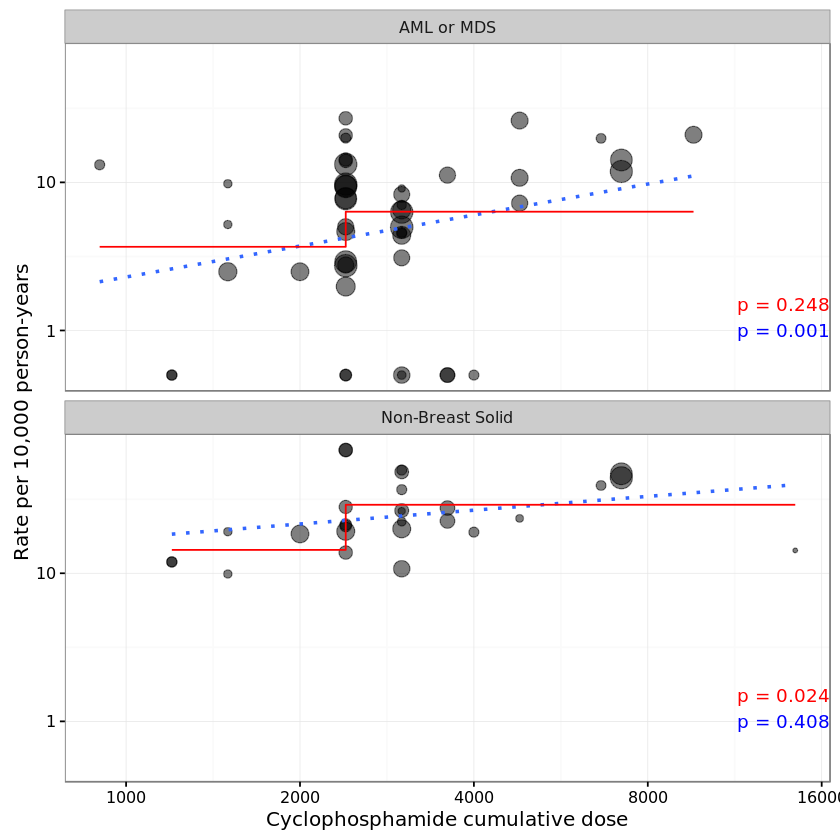

In [16]:
library(metafor)
D2 <- D1[isCyclo == TRUE,
         .(id = factor(id),
           authorYear,
           isCyclo,
           x = cyclophosphamideCumulDose,
           xHighDose = cyclophosphamideCumulDose >= 2400,
           nITT,
           medianFU,
           malType,
           malN,
           py,
           rate)]
M1 <- metareg(D2[malType == "AML or MDS"      ])
M2 <- metareg(D2[malType == "Non-Breast Solid"])
pvalues <- c(M1$pvalueLin, M1$pvalueBin, M2$pvalueLin, M2$pvalueBin)
yhat1 <- unique(data.table(malType = "AML or MDS",
                           xHighDose = as.logical(M1$rma.glmmBin$X[, "mods"]),
                           yhat = invLogit(predict(M1$rma.glmmBin)[["pred"]]) * 10000))
yhat2 <- unique(data.table(malType = "Non-Breast Solid",
                           xHighDose = as.logical(M2$rma.glmmBin$X[, "mods"]),
                           yhat = invLogit(predict(M2$rma.glmmBin)[["pred"]]) * 10000))
yhat <- rbind(yhat1, yhat2)
plotreg(D2,
        "Cyclophosphamide cumulative dose",
        1000 * c(0.5, 1, 2, 4, 8, 16),
        pvalues,
        yhat)